Train dataset: 6938 samples
Validation dataset: 1486 samples
Test dataset: 1488 samples


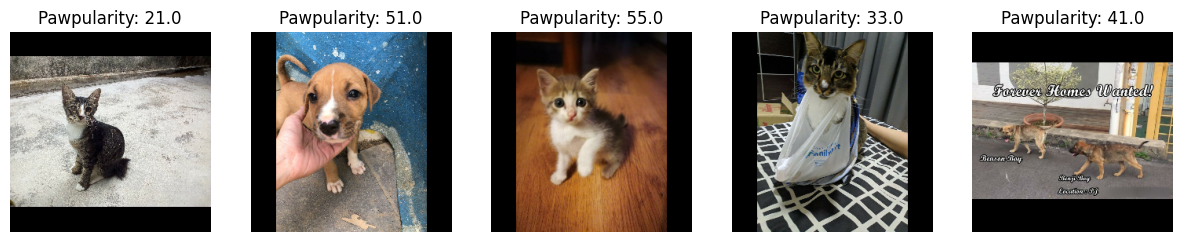

In [4]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Define constants
DATA_DIR = "train_image"
LABELS_FILE = "train.csv"
IMG_SIZE = (256, 256)  # Target size
BATCH_SIZE = 32

# Load labels
df = pd.read_csv(LABELS_FILE)
df["file_path"] = df["Id"].apply(lambda x: os.path.join(DATA_DIR, f"{x}.jpg"))

# ✅ Function for fast image loading & preprocessing
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0,1]

    # Resize while maintaining aspect ratio (padding added)
    img = tf.image.resize_with_pad(img, target_height=256, target_width=256)

    return img, tf.cast(label, tf.float32)

# ✅ Use `tf.data.Dataset` for on-the-fly image loading (MUCH FASTER)
dataset = tf.data.Dataset.from_tensor_slices((df["file_path"].values, df["Pawpularity"].values))
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# ✅ Split dataset dynamically (NO MEMORY OVERHEAD)
DATASET_SIZE = len(df)
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)

train_dataset = dataset.take(train_size).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = dataset.skip(train_size).take(val_size).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = dataset.skip(train_size + val_size).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# ✅ Print dataset sizes
print(f"Train dataset: {train_size} samples")
print(f"Validation dataset: {val_size} samples")
print(f"Test dataset: {DATASET_SIZE - train_size - val_size} samples")

# ✅ Visualize some images (No slowdown!)
X_batch, y_batch = next(iter(train_dataset.take(1)))  # Get one batch
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_batch[i].numpy())  # Convert tensor to NumPy
    ax.set_title(f"Pawpularity: {y_batch[i].numpy():.1f}")
    ax.axis("off")

plt.show()

# Model 9: Transfer Learning with EfficientNet

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load EfficientNetB0 without top layer
base_model = EfficientNetB0(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model initially

# Build model
model9 = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='linear')  # Regression output for cuteness score
])

# Compile model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model9.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Show Model Summary
model9.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 81920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    10,485,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,535,588 (55.45 MB)

 Trainable params: 10,486,017 (40.00 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
import time

# Callback to display loss at each epoch
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        t = time.monotonic() - self.time
        print('| Epoch {:2} | Time {:6.2f}s | Train Loss {:.4f} | Val Loss {:.4f} |'
              .format(epoch, t, logs['loss'], logs['val_loss']))

    def on_epoch_begin(self, epoch, logs):
        if epoch == 0:
            self.time = time.monotonic()

# Define Training Parameters
EPOCHS = 20  # Transfer learning typically needs fewer epochs
BATCH_SIZE = 32

# Early Stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model9.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, PrintLoss()]
)

Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - loss: 616.7476 - mae: 18.8037| Epoch  0 | Time 168.17s | Train Loss 545.7298 | Val Loss 414.3241 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 168s 760ms/step - loss: 616.4219 - mae: 18.7977 - val_loss: 414.3241 - val_mae: 14.6080
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - loss: 531.8488 - mae: 17.3146| Epoch  1 | Time 361.65s | Train Loss 528.6112 | Val Loss 404.6302 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 193s 883ms/step - loss: 531.8339 - mae: 17.3141 - val_loss: 404.6302 - val_mae: 15.1448
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - loss: 533.3440 - mae: 17.2558| Epoch  2 | Time 545.88s | Train Loss 525.2599 | Val Loss 404.6036 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 184s 842ms/step - loss: 533.3069 - mae: 17.2550 - val_loss: 404.6036 - val_mae: 15.1593
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - loss: 546.9410 - mae: 17.3629| Epoch  3 | Time 728.47s | Train Loss 531.9240 | Val Loss 417.1302 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 

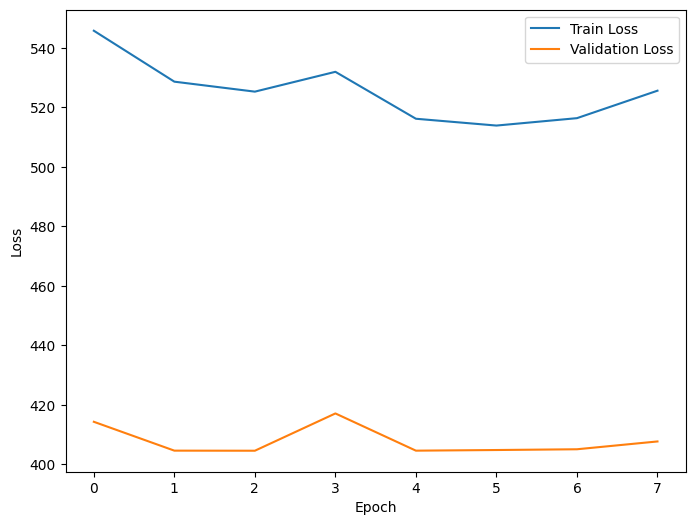

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,6))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label="Train Loss")
    plt.plot(hist['epoch'], hist['val_loss'], label="Validation Loss")
    plt.legend()
    plt.show()

# Plot the training history
plot_history(history)

In [10]:
# Evaluate model9 performance on test dataset
loss, mae = model9.evaluate(test_dataset)

print(f"Model 9 Performance on Test Set:")
print(f"Mean Squared Error (MSE): {loss:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 364ms/step - loss: 418.0972 - mae: 15.2976
Model 9 Performance on Test Set:
Mean Squared Error (MSE): 411.3403
Mean Absolute Error (MAE): 15.2555
